# Centre of a satellite orbit

This code seeks to determine the centre of a satellite orbit
## Background
Satellite state vectors define the position and velocity vectors of a satellite, usually in an Earth-Centred Earth-Fixed (ECEF) coordinate system. Examination of state vectors (for instance those that accompany SAR data, or data that is captured and recorded for Sentinel-1 at https://https://qc.sentinel1.eo.esa.int/aux_poeorb/. Upon examination of the state vector position data (perhaps by looking at 5 sequential state vectors), one finds that the magnitude of the position vector changes showing that with reference the centre of the Earth. The orbit is not locally circular.

SAR processing algorithms that are derived under the assumption of a locally circular orbit would thus not make sense because the effective velocity term used in the development of SAR processing algorithms would not have a sensible basis.

In [1]:
import numpy as np
import numpy.matlib as npmat
from scipy.linalg import expm
from scipy.optimize import minimize
import sys
import datetime
sys.path.append('/home/ishuwa_tinda/local/src/Python/radar')
import matplotlib.pyplot as plt
from measurement.measurement import state_vector_ESAEOD
from measurement.measurement import state_vector
%matplotlib notebook

## Create a state vector object

In [2]:
orbit_file = "/home/ishuwa_tinda/local/src/Python/radar/orbit/S1B_OPER_AUX_POEORB_OPOD_20180825T110641_V20180804T225942_20180806T005942.EOF"
sv = state_vector_ESAEOD()
start_date = datetime.datetime(2018,8,4,23,0,2)
end_date = datetime.datetime(2018,8,4,23,1,2)
svecs = sv.readStateVectors(orbit_file, start_date, end_date)

## Extract state vector data
The state vector contains both position and velocity components. We're only interested, at the moment, in the position elements

In [3]:
s_idx = int(len(sv.measurementTime)/2)
s_time = sv.measurementTime[s_idx]
s_vect = sv.measurementData[s_idx]
dt = 2.0
s_N = 20
sv_time_array = [s_time + datetime.timedelta(seconds = s) 
                 for s in np.arange(-s_N*dt, s_N*dt, dt)]

# Create a new state vector object to propagate
vanilla_sv = state_vector()
vanilla_sv.add(s_time, s_vect)
sv_array = vanilla_sv.estimateTimeRange(sv_time_array)
print(sv_array)
print("And")
#s_vectors = sv.measurementData
s_vectors = sv_array
print(sv.measurementData)

[array([-6.26848164e+05,  5.04565600e+06, -4.92872888e+06,  2.47279946e+03,
       -4.84456037e+03, -5.27859822e+03]), array([-6.21902585e+05,  5.03595491e+06, -4.93927500e+06,  2.47277735e+03,
       -4.85652401e+03, -5.26751260e+03]), array([-6.16957065e+05,  5.02622991e+06, -4.94979892e+06,  2.47274071e+03,
       -4.86846580e+03, -5.25640350e+03]), array([-6.12011632e+05,  5.01648106e+06, -4.96030060e+06,  2.47268953e+03,
       -4.88038568e+03, -5.24527096e+03]), array([-6.07066316e+05,  5.00670839e+06, -4.97077999e+06,  2.47262383e+03,
       -4.89228360e+03, -5.23411502e+03]), array([-6.02121146e+05,  4.99691194e+06, -4.98123704e+06,  2.47254362e+03,
       -4.90415948e+03, -5.22293575e+03]), array([-5.97176151e+05,  4.98709176e+06, -4.99167171e+06,  2.47244889e+03,
       -4.91601329e+03, -5.21173319e+03]), array([-5.92231360e+05,  4.97724790e+06, -5.00208396e+06,  2.47233966e+03,
       -4.92784496e+03, -5.20050739e+03]), array([-5.87286802e+05,  4.96738040e+06, -5.01247373e+0

## Extract the position component
The position component is extracted for two purposes
-  To demonstrate how the satellite range from the centre of the earth changes
-  To provide data to calculate a new coordinate system where the satellite orbit is locally stationary

The accompanying plot shows how the satellite radius has changed over the state vector elements. the difference in range between the first and last state vector is on the order of several meters. This different would have a large impact on SAR processing as the wavelengths of typical systems are on the order of centimeters.

<IPython.core.display.Javascript object>


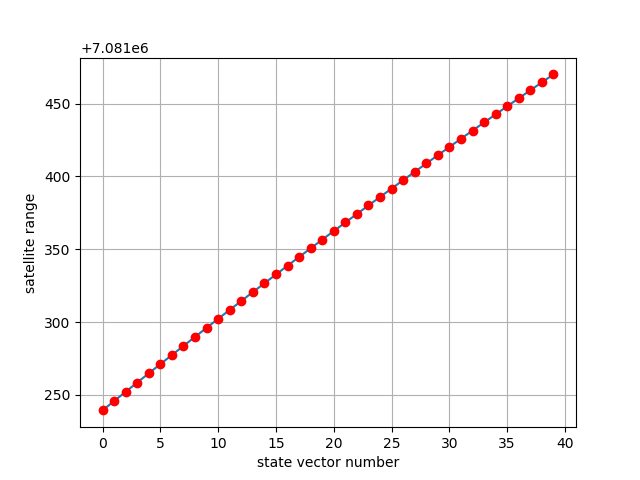

In [4]:
R = (np.array(sv_array).T)[0:4,:]
R[3,:] = 0.0
sat_ranges = np.sqrt(np.sum(R*R, axis=0))
%matplotlib notebook
plt.plot(sat_ranges)
plt.plot(sat_ranges, 'ro')
plt.ylabel('satellite range')
plt.xlabel('state vector number')
plt.grid()
plt.show()

$\newcommand{\mtx}[1]{\mathbf{#1}}$
## Calculation
The calculation machinery is defined in the next few cells.

Assume that the real centre of the orbit (local centre) is given by $\vec{c}$ and that each satellite position vector is denoted by $\vec{R}_i$, $i\in[1,N]$. Further, assume that the local circular radius is given by $r_s$.

For each state vector, on can write
\begin{align}
\lvert \vec{R}_1 - \vec{c} \rvert^2 - r^2_s &= \epsilon_1\\
\lvert \vec{R}_2 - \vec{c} \rvert^2 - r^2_s &= \epsilon_2\\
\vdots & \vdots\\
\lvert \vec{R}_N - \vec{c} \rvert^2 - r^2_s &= \epsilon_N
\end{align}

Each equation above can be recast as in the following way: first define the vectors
\begin{align}
\vec{y}_i &= \begin{bmatrix}r_{i0}\\r_{i1}\\r_{i2}\\ 0\end{bmatrix}\\
\vec{x} &= \begin{bmatrix}c_{0}\\c_{1}\\c_{2}\\r_s\end{bmatrix}
\end{align}

and also define the matrix

\begin{equation}
\mathbf{D} = \begin{bmatrix}
1&0&0&0\\
0&1&0&0\\
0&0&1&0\\
0&0&0&-1
\end{bmatrix}
\end{equation}

These definitions allow one to write each equation as
\begin{equation}
(\vec{y}_i - \vec{x})^T\mtx{D}(\vec{y}_i - \vec{x}) = \epsilon_i
\end{equation}

A suitable cost-function to minimize is thus given by
\begin{equation}
J(\vec{x}) = \sum_{i=1}^N\left[(\vec{y}_i - \vec{x})^T\mtx{D}(\vec{y}_i - \vec{x})\right]^2
\end{equation}

Some calculations show that the gradient $\vec{\nabla}_J(\vec{x})$
\begin{equation}
\begin{split}
\frac{\partial J(\vec{x})}{\partial x_m} &= \sum_{i=1}^N2\left[(\vec{y}_i - \vec{x})^T\mtx{D}(\vec{y}_i - \vec{x})\right]
\left[-\vec{e}_m^T\mtx{D}(\vec{y}_i-\vec{x}) - (\vec{y}_i-\vec{x})^T\mtx{D}\vec{e}_m\right]\\
&-4\vec{e}_m^T\mtx{D}\sum_{i=1}^N\left[(\vec{y}_i - \vec{x})^T\mtx{D}(\vec{y}_i - \vec{x})\right]
(\vec{y}_i-\vec{x})
\end{split}
\end{equation}

And that the Hessian matrix $\mtx{H}_J(\vec{x})$ has elements on row,column $(m,n)$ given by
\begin{equation}
\begin{split}
\frac{\partial^2 J(\vec{x})}{\partial x_n \partial x_m} &= 8\vec{e}_n^T\mtx{D}\left[\sum_{i=1}^N(\vec{y}_i - \vec{x})(\vec{y}_i - \vec{x})^T\right]\mtx{D}\vec{e}_m\\
&+ 4\vec{e}_n^T\mtx{D}\vec{e}_m\left[\sum_{i=1}^N(\vec{y}_i - \vec{x})^T\mtx{D}(\vec{y}_i - \vec{x})\right]
\end{split}
\end{equation}

These can be used to iterate using the Newton-Raphson method
\begin{equation}
\vec{x}_{n+1} = \vec{x}_n - \alpha\mtx{H}^{-1}_J(\vec{x}_n)\vec{\nabla}_J(\vec{x}_n)
\end{equation}
where $\alpha$ is some number less than one that controls the rate of conversion.

In [5]:
D = np.eye(4)
D[-1,-1]=-1
print(D)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


In [6]:
def J(x, R, D):
    s = 0.0
    (m,n) = R.shape
    for k in range(n):
        w = R[:,k] - x
        s += (np.dot(w,np.dot(D,w)))**2
    return s

In [7]:
def gradJ(x, R, D):
    s = np.zeros(x.shape)
    (m,n) = R.shape
    for k in range(n):
        w = R[:,k] - x
        s += -4.0*np.dot(w,np.dot(D,w))*np.dot(D,w)
    return s

In [8]:
def hessJ(x, R, D):
    s0 = 0
    s1 = np.zeros(D.shape)
    (m,n) = R.shape
    for k in range(n):
        w = R[:,k] - x
        s0 += np.dot(w,np.dot(D,w))
        s1 += np.dot(D, np.dot(np.outer(w,w),D))
    s2 = np.zeros(D.shape)
    I = np.eye(m)
    for k1 in range(m):
        for k2 in range(m):
            s2[k1,k2] = 8.0*np.dot(I[:,k1], np.dot(s1, I[:,k2]))
            s2[k1,k2] += 4.0*s0*np.dot(I[:,k1], np.dot(D, I[:,k2]))
    return s2

## Define an initial guess

In [9]:
x = np.array([0.0, 0.0, 0.0, 7081302.0])

## Start the calculation

In [10]:
err = []
for k in range(10000):
    err.append(J(x, R, D))
    x = x - 0.9*np.dot(np.linalg.inv(hessJ(x, R, D)), gradJ(x, R, D))
print(x)

[ -88062.07361313  -18481.08403143  -28597.00350816 7067323.91088807]


<IPython.core.display.Javascript object>


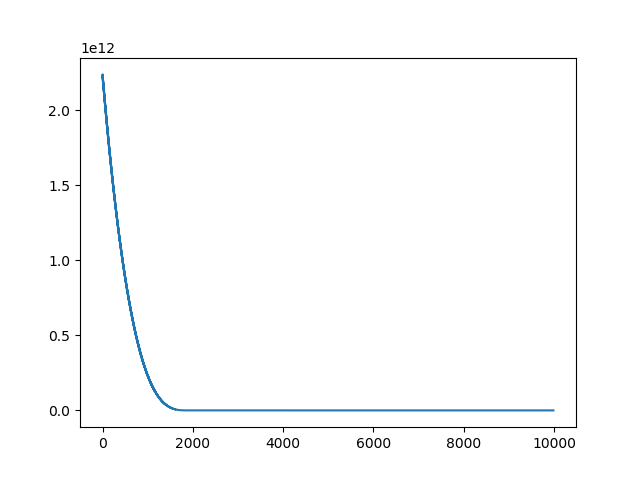

In [11]:
plt.figure()
plt.plot(err[10:])
plt.show()

In [12]:
(m,n)= R.shape
Rcentre = (R - np.matlib.repmat(x,n,1).T)[0:3,:]

In [13]:
np.sqrt(np.sum(Rcentre*Rcentre, axis=0))

array([7067323.91106298, 7067323.91097171, 7067323.91090403,
       7067323.91085654, 7067323.91082602, 7067323.91080942,
       7067323.91080365, 7067323.91080595, 7067323.91081397,
       7067323.9108256 , 7067323.91083893, 7067323.91085793,
       7067323.91087311, 7067323.91088254, 7067323.91088514,
       7067323.9108812 , 7067323.91087314, 7067323.91083061,
       7067323.91088837, 7067323.91094125, 7067323.91098951,
       7067323.91103119, 7067323.9110674 , 7067323.91109812,
       7067323.91104036, 7067323.91099368, 7067323.91094732,
       7067323.91089998, 7067323.91085203, 7067323.91080549,
       7067323.9107639 , 7067323.91073629, 7067323.91072007,
       7067323.91071795, 7067323.91073285, 7067323.91076784,
       7067323.9108257 , 7067323.91090942, 7067323.91102263,
       7067323.91116916])

# Define a rotation matrix function
Input is a vector of values that define the rotation matrix and the rotation rate as well as time

Assume the we have a rotation vector $\vec{k}(t)$ around which the satellite orbits. Also, that it rotates with angular rate $\omega_s(t)$. The previous material has already shown that the satellite stays at a consant range. The input vector is $\vec{x}$ with the model that
\begin{equation}
 \omega_s\mtx{K}(t) = \omega_s[\mtx{K}_0 + \mtx{K}_1t]
\end{equation}

In [14]:
def rotationMatrix(k, t):
    """
    The vectors k=[k0,k1] determine the anti-symmetric group algebra coefficients
    
    The variable t represents time.
    
    The overall rotation matrix group algebra element is given by 
    X = \int_0^t K_0 + tK_1 = tK_0 + \frac{1}{2}t^2K_1
    """
    k0=k[0:3]
    k1=k[3:]
    
    X0 = np.array([[ 0.0,   -k0[2],  k0[1]],
                   [ k0[2],  0.0,   -k0[0]],
                   [-k0[1],  k0[0],  0.0  ]])
    X1 = np.array([[ 0.0,   -k1[2],  k1[1]],
                   [ k1[2],  0.0,   -k1[0]],
                   [-k1[1],  k1[0],  0.0  ]])
    
    X = t*X0 + t**2/2.0*X1
    
    return expm(X)

In [15]:
def computeInitialK(r2,r1, dt=10.0):
    # Compute a guess for the rotation vector 
    # Use the cross product
    w0 = np.cross(r2, r1)
    w0 = w0/np.linalg.norm(w0)
    
    # Compute a guess for the rotation rate
    angularRate = np.arccos(np.dot(r1, r2)/np.linalg.norm(r1)/np.linalg.norm(r2))/dt
    
    k0 = angularRate*w0
    k1 = np.zeros(k0.shape)
    
    return np.array([k0,k1]).flatten()

In [16]:
k = computeInitialK(Rcentre[:,0], Rcentre[:,1], dt)
print(k)

[-0.00101051 -0.00029948 -0.00019839  0.          0.          0.        ]


In [17]:
R = rotationMatrix(k, dt)
print(R)

[[ 9.99999742e-01  3.97390908e-04 -5.98554944e-04]
 [-3.96180410e-04  9.99997879e-01  2.02113002e-03]
 [ 5.99356853e-04 -2.02089236e-03  9.99997778e-01]]


In [18]:
print(Rcentre[:,0])
print(Rcentre[:,1])
print(np.dot(R,Rcentre[:,0]))

[ -538786.09079291  5064137.080231   -4900131.88035589]
[ -533840.51153124  5054435.99217235 -4910677.99513196]
[ -533840.51153804  5054435.99223744 -4910677.99519557]


In [19]:
def costAngular(k, dt):
    (m,n) = Rcentre.shape
    v = Rcentre[:,0]
    err = []
    for tidx in range(n):
        v_actual = Rcentre[:,tidx]
        v_model = np.dot(rotationMatrix(k, tidx*dt), v)
        err.append(np.linalg.norm(v_actual-v_model)**2)
    return sum(err)

In [20]:
res = minimize(costAngular, k, args=dt, method='nelder-mead', options={'xatol':1e-9, 'maxiter':2000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.345026
         Iterations: 310
         Function evaluations: 524


In [21]:
xF = res['x']
res

 final_simplex: (array([[-1.01052666e-03, -2.99129141e-04, -1.98856018e-04,
        -3.10103621e-08,  1.11237563e-07,  1.55157281e-08],
       [-1.01052665e-03, -2.99129165e-04, -1.98855997e-04,
        -3.10092156e-08,  1.11223048e-07,  1.55311557e-08],
       [-1.01052668e-03, -2.99129077e-04, -1.98856063e-04,
        -3.10114958e-08,  1.11254475e-07,  1.54976818e-08],
       [-1.01052669e-03, -2.99128994e-04, -1.98856114e-04,
        -3.10138107e-08,  1.11279323e-07,  1.54708998e-08],
       [-1.01052668e-03, -2.99129091e-04, -1.98856044e-04,
        -3.10105671e-08,  1.11245050e-07,  1.55074145e-08],
       [-1.01052665e-03, -2.99129197e-04, -1.98855996e-04,
        -3.10088524e-08,  1.11222862e-07,  1.55323297e-08],
       [-1.01052667e-03, -2.99129026e-04, -1.98856084e-04,
        -3.10127018e-08,  1.11265937e-07,  1.54846756e-08]]), array([0.34502646, 0.34503646, 0.34504299, 0.34507869, 0.345085  ,
       0.3450919 , 0.34510749]))
           fun: 0.34502645805939103
       messa

In [22]:
(m,n) = Rcentre.shape
diff = []
for tidx in range(n):
    R = rotationMatrix(xF, tidx*dt)
    print(Rcentre[:,tidx])
    print(np.dot(R,Rcentre[:,0]))
    diff.append(Rcentre[:,tidx] - np.dot(R,Rcentre[:,0]))
    print(diff[-1])
    print("")

[ -538786.09079291  5064137.080231   -4900131.88035589]
[ -538786.09079291  5064137.080231   -4900131.88035589]
[0. 0. 0.]

[ -533840.51153124  5054435.99217235 -4910677.99513196]
[ -533840.49894115  5054435.96893962 -4910678.02054484]
[-0.01259009  0.02323273  0.02541288]

[ -528894.99102733  5044710.99867819 -4921201.91517451]
[ -528894.96816715  5044710.95619601 -4921201.96140801]
[-0.02286018  0.04248219  0.04623349]

[ -523949.5583509   5034962.14351368 -4931703.59355188]
[ -523949.52738434  5034962.08555036 -4931703.65631458]
[-0.03096656  0.05796332  0.0627627 ]

[ -519004.24255751  5025189.47055696 -4942182.98343393]
[ -519004.20549382  5025189.40066348 -4942183.05873241]
[-0.03706369  0.06989348  0.07529848]

[ -514059.07268839  5015393.02379888 -4952640.03809229]
[ -514059.03138425  5015392.94530654 -4952640.12222816]
[-0.04130414  0.07849234  0.08413587]

[ -509114.07776723  5005572.84733905 -4963074.71090434]
[ -509114.03393166  5005572.76336089 -4963074.80046755]
[-0.04383

In [23]:
costAngular(xF, dt)

0.34502645805939103

In [24]:
ndiff = np.array(diff)

<IPython.core.display.Javascript object>


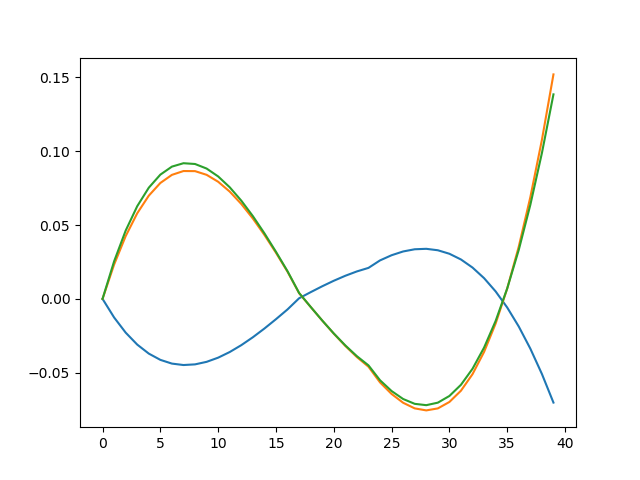

In [25]:
plt.figure()
plt.plot(ndiff)
plt.show()